In [ ]:
# Using a custom kernel (neural network model) within the 
# MICE implementation instead of the default estimators provided by scikit-learn. 
# Created a custom estimator compatible with the scikit-learn interface.

In [1]:
import os

# Define the path to the directory you want to switch to
new_directory = "C:\\Users\gaurav.goyal\Downloads"

# Change to the new directory
os.chdir(new_directory)

# Check the current working directory
print("Current Working Directory:", os.getcwd())

Current Working Directory: C:\Users\gaurav.goyal\Downloads


In [2]:
from tensorflow import keras

In [3]:
import tensorflow as tf

# Create a Sequential model
model = tf.keras.Sequential()

# Add dense layers
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Add an EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping()

print("Successfully imported Keras modules from TensorFlow.")

Successfully imported Keras modules from TensorFlow.


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3741
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1463 
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1032 
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0963 
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0886 
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0883 
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0895 
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0770 
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0847 
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 0.0816
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0784 
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0751 
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0871 
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0852 
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - los

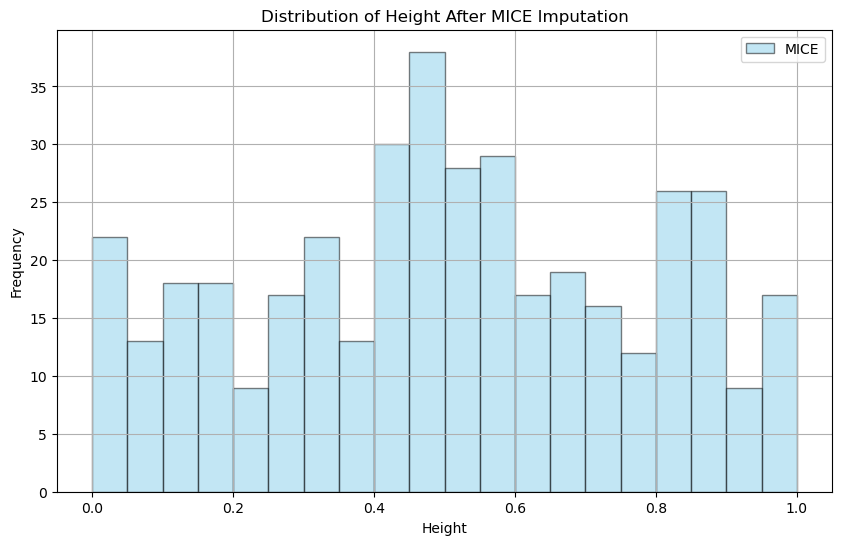

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.base import BaseEstimator, RegressorMixin
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_excel('Parts and Dimesions.xlsx')

# Step 1: Remove Missing Data
data_cleaned = data.dropna(subset=['Length', 'Width', 'Height'])

# Step 2: Remove Outliers using Isolation Forest
isolation_forest = IsolationForest(random_state=42)
outliers = isolation_forest.fit_predict(data_cleaned[['Length', 'Width', 'Height']])
data_no_outliers = data_cleaned[outliers == 1]

# Step 3: Normalize Data using Min-Max Scaling
scaler = MinMaxScaler()
data_no_outliers.loc[:, ['Length', 'Width', 'Height']] = scaler.fit_transform(data_no_outliers[['Length', 'Width', 'Height']])

# Simulate missing data in 'Height' for demonstration
np.random.seed(42)
missing_indices = np.random.choice(data_no_outliers.index, size=int(0.1 * len(data_no_outliers)), replace=False)
data_no_outliers.loc[missing_indices, 'Height'] = np.nan

# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Compile and fit the model
X_train = data_no_outliers.dropna(subset=['Height'])[['Length', 'Width']]
y_train = data_no_outliers.dropna(subset=['Height'])['Height']
model.fit(X_train, y_train, epochs=100, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)], verbose=1)

# Define custom kernel for MICE
class NeuralNetworkKernel(BaseEstimator, RegressorMixin):
    def __init__(self, model=None):
        self.model = model

    def fit(self, X, y):
        # Assume model is pre-trained.
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()  # Flatten is necessary to ensure the output shape is correct.

    def get_params(self, deep=True):
        return {'model': self.model}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# Initialize the custom neural network estimator
neural_estimator = NeuralNetworkKernel(model=model)

# Data Imputation using MICE with custom kernel
imputer_mice = IterativeImputer(random_state=42, estimator=neural_estimator)
data_mice_imputed = imputer_mice.fit_transform(data_no_outliers[['Length', 'Width', 'Height']])

# Convert imputed data back to DataFrame
data_mice_imputed_df = pd.DataFrame(data_mice_imputed, columns=['Length', 'Width', 'Height'], index=data_no_outliers.index)

# Display the imputation results in table form
print("MICE Imputation Results:")
print(data_mice_imputed_df.loc[missing_indices].head())

# Visualizations
plt.figure(figsize=(10, 6))

# Histogram for MICE-imputed data
plt.hist(data_mice_imputed_df['Height'], bins=20, color='skyblue', edgecolor='black', alpha=0.5, label='MICE')

plt.title('Distribution of Height After MICE Imputation')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()